<a href="https://colab.research.google.com/github/CamiloVga/Curso-IA-Aplicada/blob/main/Script_20_RNN_para_An%C3%A1lisis_de_Sentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Inteligencia Artificial Aplicada para la Economía
## Universidad de los Andes

### 👨‍🏫 Profesores
- **Profesor Magistral:** [Camilo Vega Barbosa](https://www.linkedin.com/in/camilovegabarbosa/)
- **Asistente de Docencia:** [Sergio Julian Zona Moreno](https://www.linkedin.com/in/sergiozonamoreno/)

### 📚 Análisis de Sentimiento con RNN para Textos Financieros
Este notebook demuestra la implementación práctica de Redes Neuronales Recurrentes (RNN) para el análisis de sentimiento en textos financieros:

1. **Preprocesamiento de Texto 🧹**
   - Limpieza y normalización de textos financieros
   - Tokenización especializada
   - Manejo de vocabulario técnico del sector financiero

2. **Arquitecturas RNN Avanzadas 🧠**
   - Simple RNN: Fundamentos de procesamiento secuencial
   - LSTM: Manejo de dependencias a largo plazo
   - GRU: Optimización computacional con rendimiento comparable
   - Redes Bidireccionales: Captura de contexto completo

3. **Embeddings Semánticos 🔤**
   - Embeddings tradicionales vs. BERT
   - Transferencia de conocimiento desde modelos preentrenados
   - Representación contextual de términos financieros

4. **Optimización de Hiperparámetros 📊**
   - Grid Search exhaustivo
   - Evaluación comparativa de arquitecturas
   - Métricas de rendimiento especializadas
   - Visualización de resultados experimentales

### 🎯 Objetivo
Desarrollar un clasificador de sentimiento financiero optimizado mediante:
- Comparación sistemática de arquitecturas RNN
- Evaluación del impacto de embeddings BERT especializados
- Selección de hiperparámetros óptimos basada en precisión y F1-Score
- Análisis visual del rendimiento de modelos

### 🔍 Aplicaciones Prácticas:
- Análisis automatizado de noticias financieras
- Predicción de impacto de comunicados corporativos
- Monitoreo de sentimiento en reportes de mercado
- Detección temprana de tendencias económicas

### Requisitos Técnicos:
- **Entorno de Ejecución**: Google Colab con GPU
- **Bibliotecas Necesarias**:
  - TensorFlow 2.x
  - Transformers (Hugging Face)
  - NLTK
  - Pandas y NumPy
  - Matplotlib y Seaborn
- **Memoria RAM**: Mínimo 8GB recomendados
- **Tiempo Estimado**: 30-45 minutos para grid search completo

In [1]:
#####################################################################
# SECCIÓN 1: INSTALACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL
#####################################################################

# Instalación de paquetes necesarios
!pip install transformers datasets tensorflow nltk scikit-learn matplotlib pandas -q

# Importaciones principales organizadas por categoría
# --- Análisis de datos y visualización ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Procesamiento de lenguaje natural ---
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel

# --- Modelos de Deep Learning ---
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Evaluación de modelos ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Otros utilitarios ---
from datasets import load_dataset
import time
import itertools

# Descarga recursos de NLTK necesarios
nltk.download('punkt', quiet=True)

# Configurar semilla aleatoria para reproducibilidad
# Esto asegura que los resultados sean consistentes en múltiples ejecuciones
np.random.seed(42)
tf.random.set_seed(42)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

## Base de Datos y preprocesamiento

**Este bloque de código** se encarga del preprocesamiento de una **base de datos de noticias financieras**, que contiene textos clasificados según su sentimiento respecto a los mercados financieros: **positivo (2), neutral (1) o negativo (0)**.

La sección comienza cargando el dataset principal "**ashraq/financial-news-articles**", pero incluye **mecanismos de respaldo** en caso de fallo, utilizando alternativamente "financial_phrasebank" o, como último recurso, creando datos de ejemplo con textos financieros básicos.

El código realiza una **exploración inicial de los datos**, asegurando que existan columnas de texto y etiquetas de sentimiento. Si no hay etiquetas disponibles, implementa un **clasificador básico basado en palabras clave** financieras (como "rise" y "gain" para sentimiento positivo o "fall" y "loss" para negativo).

A continuación, aplica **técnicas esenciales de preprocesamiento de texto**: conversión a minúsculas, eliminación de caracteres especiales y normalización de espacios. Los datos se dividen en **conjuntos de entrenamiento (80%) y prueba (20%)**, manteniendo la distribución de las clases mediante estratificación.

Finalmente, realiza la **tokenización de los textos**, convirtiéndolos en secuencias numéricas de longitud uniforme, y carga un **modelo BERT preentrenado** para generar embeddings avanzados. Estos embeddings proporcionan **representaciones vectoriales ricas en contexto** para las palabras del vocabulario financiero, lo que permitirá a las redes neuronales recurrentes capturar mejor los matices semánticos asociados al sentimiento de las noticias financieras.

In [2]:

#####################################################################
# SECCIÓN 2: PREPROCESAMIENTO DE LA BASE DE DATOS
#####################################################################

print("Cargando dataset de noticias financieras...")

try:
    # Usamos streaming=True para procesar el dataset en tiempo real
    # sin necesidad de cargarlo completo en memoria
    dataset = load_dataset("ashraq/financial-news-articles",
                         split="train[:1000]",
                         streaming=True,
                         trust_remote_code=True)

    # Convertir a lista y luego a DataFrame
    data_list = list(dataset.take(1000))  # Limitamos a 1000 ejemplos para mayor eficiencia
    df = pd.DataFrame(data_list)

except Exception as e:
    print(f"Error al cargar el dataset: {e}")
    print("\nUtilizando dataset alternativo como respaldo...")

    # Plan de respaldo si la carga de datos falla
    try:
        dataset = load_dataset("financial_phrasebank",
                              "sentences_allagree",
                              split="train[:1000]")
        df = pd.DataFrame(dataset)
    except:
        print("También falló el dataset alternativo. Creando datos de ejemplo...")
        # Datos mínimos de ejemplo como último recurso
        texts = ["Stock market rises after positive report",
                "Company announces layoffs",
                "Federal Reserve maintains interest rates"]
        labels = [2, 0, 1]  # 2=positivo, 0=negativo, 1=neutral
        df = pd.DataFrame({"text": texts, "label": labels})

# Exploración básica del dataset
print("\nInformación del dataset:")
print(f"Número de ejemplos: {len(df)}")
print("\nPrimeras filas del dataset:")
print(df.head())

# Asegurar que tengamos columnas de texto y etiquetas
if 'text' not in df.columns:
    if 'sentence' in df.columns:
        df['text'] = df['sentence']
    else:
        # Buscar una columna que pueda contener texto
        text_columns = [col for col in df.columns if df[col].dtype == 'object']
        if text_columns:
            df['text'] = df[text_columns[0]]
        else:
            raise ValueError("No se encuentra columna de texto en el dataset")

if 'label' not in df.columns:
    print("No se encuentra columna de etiquetas. Creando etiquetas artificiales...")
    # Asignar etiquetas artificiales basadas en palabras clave
    positive_words = ['up', 'rise', 'increase', 'grow', 'gain', 'positive', 'profit']
    negative_words = ['down', 'fall', 'decrease', 'loss', 'negative', 'cut', 'weak']

    # NOTA PARA ESTUDIANTES: Este es un clasificador simple basado en palabras clave
    def simple_sentiment(text):
        text = str(text).lower()
        pos_count = sum(1 for word in positive_words if word in text)
        neg_count = sum(1 for word in negative_words if word in text)

        if pos_count > neg_count:
            return 2  # Positivo
        elif neg_count > pos_count:
            return 0  # Negativo
        else:
            return 1  # Neutral

    df['label'] = df['text'].apply(simple_sentiment)

# Ver distribución de etiquetas
print("\nDistribución de etiquetas:")
print(df['label'].value_counts())

# Preprocesamiento de texto
print("\nPreparando los datos...")

def preprocess_text(text):
    # Verificar tipo de dato
    if not isinstance(text, str):
        text = str(text)

    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales y números - solo conservamos letras
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Aplicar preprocesamiento
df['processed_text'] = df['text'].apply(preprocess_text)

# NOTA PARA ESTUDIANTES: Es importante separar datos de entrenamiento y prueba
# para evaluar correctamente el rendimiento del modelo
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

print(f"Tamaño conjunto entrenamiento: {len(X_train)}")
print(f"Tamaño conjunto prueba: {len(X_test)}")

# Tokenización usando TensorFlow
print("\nTokenizando textos...")


# max_words: limita el tamaño del vocabulario a las palabras más frecuentes
# max_len: establece la longitud máxima de las secuencias
max_words = 10000  # Tamaño del vocabulario
max_len = 100      # Longitud máxima de secuencia (en tokens)

# El tokenizador convierte palabras en números (índices)
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')  # OOV = Out Of Vocabulary
tokenizer.fit_on_texts(X_train)  # Aprende el vocabulario del conjunto de entrenamiento

# Convertir textos a secuencias de índices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding: hacer que todas las secuencias tengan la misma longitud
# NOTA PARA ESTUDIANTES: El padding es necesario porque las RNNs necesitan
# entradas de longitud consistente para procesar los lotes eficientemente
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Tamaño real del vocabulario (limitado por max_words)
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
print(f"Tamaño del vocabulario: {vocab_size} palabras únicas")

# Cargar BERT para embeddings
print("\nCargando modelo BERT para embeddings...")

# NOTA PARA ESTUDIANTES: BERT es un modelo potente de embeddings preentrenado
# que captura relaciones semánticas entre palabras basadas en su contexto
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def get_bert_embeddings(tokenizer, bert_tokenizer, bert_model, vocab_size=10000, embedding_dim=768):
    print("Generando embeddings BERT para el vocabulario...")
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Limitamos a las 200 palabras más frecuentes para ahorrar tiempo
    # En un escenario real, se procesaría todo el vocabulario
    words = []
    for word, idx in tokenizer.word_index.items():
        if idx < 200:
            words.append(word)

    # Calcular embeddings para cada palabra
    for word in words:
        idx = tokenizer.word_index[word]
        if idx >= vocab_size:
            continue

        # Tokenizar la palabra con BERT
        bert_tokens = bert_tokenizer(word, return_tensors='tf')

        # Obtener salida del modelo BERT
        outputs = bert_model(bert_tokens)

        # Usar la representación del token
        word_embedding = outputs.last_hidden_state.numpy()[:, 1, :]
        embedding_matrix[idx] = word_embedding

    print(f"Embeddings BERT generados para {len(words)} palabras")
    return embedding_matrix

# Obtener matriz de embeddings BERT
bert_embedding_matrix = get_bert_embeddings(
    tokenizer,
    bert_tokenizer,
    bert_model,
    vocab_size=vocab_size
)



Cargando dataset de noticias financieras...


README.md:   0%|          | 0.00/543 [00:00<?, ?B/s]

Error al cargar el dataset: Bad split: train[:1000]. Available splits: ['train']

Utilizando dataset alternativo como respaldo...


README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]


Información del dataset:
Número de ejemplos: 1000

Primeras filas del dataset:
                                            sentence  label
0  According to Gran , the company has no plans t...      1
1  For the last quarter of 2010 , Componenta 's n...      2
2  In the third quarter of 2010 , net sales incre...      2
3  Operating profit rose to EUR 13.1 mn from EUR ...      2
4  Operating profit totalled EUR 21.1 mn , up fro...      2

Distribución de etiquetas:
label
2    542
1    424
0     34
Name: count, dtype: int64

Preparando los datos...
Tamaño conjunto entrenamiento: 800
Tamaño conjunto prueba: 200

Tokenizando textos...
Tamaño del vocabulario: 2986 palabras únicas

Cargando modelo BERT para embeddings...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Generando embeddings BERT para el vocabulario...
Embeddings BERT generados para 199 palabras


## Entrenamiento de diferentes RNN para análisis de sentimiento

**Esta sección del código** implementa y evalúa diferentes arquitecturas de **Redes Neuronales Recurrentes (RNN)** para la clasificación de sentimiento en textos financieros.

El proceso comienza definiendo una **función flexible para crear modelos RNN** que permite experimentar con distintas configuraciones: **SimpleRNN básicas, LSTM con memoria de largo plazo, o GRU más eficientes computacionalmente**. La función también incorpora opciones para utilizar **capas bidireccionales** (que procesan el texto en ambas direcciones) y elegir entre **embeddings tradicionales o pre-entrenados de BERT**.

El núcleo de esta sección es la implementación de un exhaustivo **Grid Search**, una técnica de optimización que prueba sistemáticamente **24 combinaciones diferentes de hiperparámetros** (3 tipos de RNN × 2 opciones de bidireccionalidad × 2 tamaños de unidades × 2 tasas de aprendizaje), tanto con embeddings tradicionales como con BERT, resultando en **48 modelos evaluados en total**.

Para cada modelo, se registran métricas clave como **accuracy, F1-score y tiempo de ejecución**. El código implementa **early stopping** para evitar sobreajuste, deteniendo el entrenamiento cuando el rendimiento deja de mejorar en el conjunto de validación.

Finalmente, todos los resultados se combinan, ordenan por precisión, y se presentan los **5 mejores modelos** con sus configuraciones detalladas, proporcionando una visión clara de qué arquitecturas y parámetros ofrecen mejor rendimiento para la clasificación de sentimiento en textos financieros.




In [3]:

#####################################################################
# SECCIÓN 3: IMPLEMENTACIÓN Y EVALUACIÓN DE MODELOS RNN
#####################################################################

print("\nPreparando Grid Search para RNN...")

# Determinar número de clases para la capa de salida
num_classes = len(df['label'].unique())
print(f"Número de clases a predecir: {num_classes}")

# Función para crear diferentes modelos RNN
def create_rnn_model(model_type='lstm', bidirectional=False, units=64,
                   learning_rate=0.001, dropout_rate=0.3, use_bert=False):
    """
    Crea un modelo RNN con diferentes configuraciones

    Args:
        model_type: Tipo de celda recurrente ('simple_rnn', 'lstm', 'gru')
        bidirectional: Si usar capa bidireccional
        units: Número de unidades en la capa recurrente
        learning_rate: Tasa de aprendizaje
        dropout_rate: Tasa de dropout
        use_bert: Si usar embeddings BERT pre-entrenados
    """
    # Input layer - recibe secuencias de índices
    inp = Input(shape=(max_len,))

    # Embedding layer - convierte índices en vectores densos
    if use_bert:
        # Usar embeddings BERT (enfoque de transfer learning)
        x = Embedding(
            input_dim=vocab_size,
            output_dim=bert_embedding_matrix.shape[1],
            weights=[bert_embedding_matrix],
            input_length=max_len,
            trainable=False  # No se actualizan durante el entrenamiento
        )(inp)
    else:
        # Embedding tradicional (se aprende durante el entrenamiento)
        x = Embedding(
            input_dim=vocab_size,
            output_dim=128,  # Dimensionalidad del embedding (hiperparámetro)
            input_length=max_len
        )(inp)

    # Seleccionar tipo de capa recurrente
    # NOTA PARA ESTUDIANTES: Cada tipo tiene características diferentes:
    # - SimpleRNN: La más básica, problemas con dependencias largas
    # - LSTM: Mejor memoria de largo plazo, más parámetros
    # - GRU: Similar a LSTM pero más eficiente computacionalmente
    if model_type == 'simple_rnn':
        rnn_layer = SimpleRNN(units, return_sequences=True)
    elif model_type == 'lstm':
        rnn_layer = LSTM(units, return_sequences=True)
    else:  # gru
        rnn_layer = GRU(units, return_sequences=True)

    # Aplicar capa recurrente
    if bidirectional:
        x = Bidirectional(rnn_layer)(x)
    else:
        x = rnn_layer(x)

    # Global Pooling - colapsa la secuencia a un vector fijo
    x = GlobalMaxPooling1D()(x)

    # Dropout - técnica de regularización para evitar sobreajuste
    x = Dropout(dropout_rate)(x)

    # Capa de salida - softmax para clasificación multiclase
    out = Dense(num_classes, activation='softmax')(x)

    # Compilar modelo
    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',  # Para etiquetas enteras (no one-hot)
        metrics=['accuracy']
    )

    return model

# Definir parámetros para el grid search
param_grid = {
    'model_type': ['simple_rnn', 'lstm', 'gru'],           # Tipo de RNN
    'bidirectional': [False, True],                         # Usar o no capa bidireccional
    'units': [32, 64],                                      # Número de unidades (neuronas)
    'learning_rate': [0.001, 0.0001],                       # Tasa de aprendizaje
    'batch_size': [32],                                     # Tamaño del lote
    'epochs': [5]                                           # Épocas de entrenamiento
}

# Función para realizar grid search
def run_grid_search(param_grid, X_train, y_train, X_val, y_val, use_bert=False):
    """
    Realiza grid search sobre los hiperparámetros
    """
    # Generar todas las combinaciones posibles de hiperparámetros
    keys = param_grid.keys()
    combinations = list(itertools.product(*param_grid.values()))
    param_combinations = [dict(zip(keys, combo)) for combo in combinations]

    # Lista para almacenar resultados
    results = []

    print(f"Probando {len(param_combinations)} combinaciones de modelos...")

    # Probar cada combinación
    for i, params in enumerate(param_combinations):
        start_time = time.time()

        # Extraer parámetros
        model_type = params['model_type']
        bidirectional = params['bidirectional']
        units = params['units']
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        # Crear nombre descriptivo para el modelo
        model_name = f"{model_type.upper()}"
        if bidirectional:
            model_name = f"Bi{model_name}"
        model_name += f"_u{units}_lr{learning_rate}"
        if use_bert:
            model_name += "_BERT"

        print(f"\n[{i+1}/{len(param_combinations)}] Entrenando {model_name}...")

        # Crear modelo con los parámetros actuales
        model = create_rnn_model(
            model_type=model_type,
            bidirectional=bidirectional,
            units=units,
            learning_rate=learning_rate,
            dropout_rate=0.3,  # Fijo para simplificar
            use_bert=use_bert
        )

        # Early stopping - detiene el entrenamiento cuando deja de mejorar
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=2,  # Número de épocas sin mejora antes de detenerse
            restore_best_weights=True  # Restaura los mejores pesos encontrados
        )

        # Entrenar modelo
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluar modelo en conjunto de validación
        y_pred_probs = model.predict(X_val)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Calcular métricas de rendimiento
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')

        # Tiempo de ejecución
        execution_time = time.time() - start_time

        # Guardar resultados
        result = {
            'model_name': model_name,
            'model_type': model_type,
            'bidirectional': bidirectional,
            'units': units,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'accuracy': accuracy,
            'f1_score': f1,
            'execution_time': execution_time,
            'use_bert': use_bert
        }

        results.append(result)

        print(f"Resultado: Acc={accuracy:.4f}, F1={f1:.4f}, Tiempo={execution_time:.1f}s")

    # Ordenar resultados por precisión (de mayor a menor)
    results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)

    return results_sorted

# Ejecutar grid search con embeddings tradicionales
print("\nEjecutando grid search con embeddings tradicionales...")
results_traditional = run_grid_search(
    param_grid,
    X_train_pad,
    y_train,
    X_test_pad,
    y_test,
    use_bert=False
)

# Ejecutar grid search con BERT embeddings
print("\nEjecutando grid search con embeddings BERT...")
results_bert = run_grid_search(
    param_grid,
    X_train_pad,
    y_train,
    X_test_pad,
    y_test,
    use_bert=True
)

# Combinar y ordenar todos los resultados
all_results = results_traditional + results_bert
all_results_sorted = sorted(all_results, key=lambda x: x['accuracy'], reverse=True)

# Mostrar los mejores resultados
print("\n=== RESULTADOS DEL GRID SEARCH ===")
print("\nTop modelos por precisión:")
for i, result in enumerate(all_results_sorted[:5]):
    print(f"\n{i+1}. {result['model_name']}:")
    print(f"   Accuracy: {result['accuracy']:.4f}")
    print(f"   F1-Score: {result['f1_score']:.4f}")
    print(f"   Tiempo: {result['execution_time']:.1f}s")
    print(f"   Usa BERT: {result['use_bert']}")
    print(f"   Tipo: {result['model_type'].upper()}, Bidireccional: {result['bidirectional']}")

# Crear DataFrame para visualización
results_df = pd.DataFrame(all_results_sorted)




Preparando Grid Search para RNN...
Número de clases a predecir: 3

Ejecutando grid search con embeddings tradicionales...
Probando 24 combinaciones de modelos...

[1/24] Entrenando SIMPLE_RNN_u32_lr0.001...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4535 - loss: 0.9674 - val_accuracy: 0.5400 - val_loss: 0.7928
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6378 - loss: 0.7517 - val_accuracy: 0.5750 - val_loss: 0.7489
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7087 - loss: 0.6705 - val_accuracy: 0.6400 - val_loss: 0.6968
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8516 - loss: 0.5228 - val_accuracy: 0.7050 - val_loss: 0.6293
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9089 - loss: 0.4453 - val_accuracy: 0.8450 - val_loss: 0.5411
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Resultado: Acc=0.8450, F1=0.8299, Tiempo=9.3s

[2/24] Entrenando SIMPLE_RNN_u32_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.2304 - loss: 1.1748 - val_accuracy: 0.4250 - val_loss: 1.0813
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4117 - loss: 1.0741 - val_accuracy: 0.5900 - val_loss: 1.0055
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5753 - loss: 0.9797 - val_accuracy: 0.6250 - val_loss: 0.9547
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5979 - loss: 0.9281 - val_accuracy: 0.6650 - val_loss: 0.9151
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6385 - loss: 0.8735 - val_accuracy: 0.7050 - val_loss: 0.8743
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Resultado: Acc=0.7050, F1=0.6846, Tiempo=10.7s

[3/24] Entrenando SIMPLE_RNN_u64_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.4164 - loss: 0.9831 - val_accuracy: 0.5400 - val_loss: 0.8284
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5734 - loss: 0.8154 - val_accuracy: 0.5400 - val_loss: 0.7689
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7069 - loss: 0.6823 - val_accuracy: 0.7950 - val_loss: 0.5970
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8805 - loss: 0.4635 - val_accuracy: 0.8250 - val_loss: 0.5066
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9408 - loss: 0.3044 - val_accuracy: 0.7950 - val_loss: 0.5567


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Resultado: Acc=0.8250, F1=0.8086, Tiempo=16.2s

[4/24] Entrenando SIMPLE_RNN_u64_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.3013 - loss: 1.1596 - val_accuracy: 0.5250 - val_loss: 1.0084
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5230 - loss: 0.9790 - val_accuracy: 0.5950 - val_loss: 0.9144
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5814 - loss: 0.8946 - val_accuracy: 0.5750 - val_loss: 0.8575
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6481 - loss: 0.8452 - val_accuracy: 0.6550 - val_loss: 0.8068
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6808 - loss: 0.7732 - val_accuracy: 0.6700 - val_loss: 0.7506


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Resultado: Acc=0.6700, F1=0.6457, Tiempo=14.7s

[5/24] Entrenando BiSIMPLE_RNN_u32_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.4536 - loss: 0.9888 - val_accuracy: 0.7050 - val_loss: 0.6821
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7858 - loss: 0.5983 - val_accuracy: 0.7750 - val_loss: 0.5663
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9111 - loss: 0.3551 - val_accuracy: 0.8000 - val_loss: 0.5626
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9498 - loss: 0.2429 - val_accuracy: 0.7450 - val_loss: 0.6074
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9361 - loss: 0.2376 - val_accuracy: 0.7850 - val_loss: 0.5985
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Resultado: Acc=0.8000, F1=0.7829, Tiempo=11.5s

[6/24] Entrenando BiSIMPLE_RNN_u32_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.4106 - loss: 1.1634 - val_accuracy: 0.4950 - val_loss: 1.0203
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5366 - loss: 0.9979 - val_accuracy: 0.5750 - val_loss: 0.9516
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5951 - loss: 0.9168 - val_accuracy: 0.5700 - val_loss: 0.9104
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6296 - loss: 0.8786 - val_accuracy: 0.6000 - val_loss: 0.8775
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6625 - loss: 0.8309 - val_accuracy: 0.6400 - val_loss: 0.8445
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Resultado: Acc=0.6400, F1=0.5783, Tiempo=10.1s

[7/24] Entrenando BiSIMPLE_RNN_u64_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.4990 - loss: 0.9120 - val_accuracy: 0.5400 - val_loss: 0.7534
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7128 - loss: 0.6627 - val_accuracy: 0.8300 - val_loss: 0.5135
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9029 - loss: 0.4219 - val_accuracy: 0.7950 - val_loss: 0.5640
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9351 - loss: 0.2781 - val_accuracy: 0.7700 - val_loss: 0.6033
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Resultado: Acc=0.8300, F1=0.8151, Tiempo=9.2s

[8/24] Entrenando BiSIMPLE_RNN_u64_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.2916 - loss: 1.2039 - val_accuracy: 0.4300 - val_loss: 0.9436
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5265 - loss: 0.9154 - val_accuracy: 0.5450 - val_loss: 0.8551
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5675 - loss: 0.8407 - val_accuracy: 0.5400 - val_loss: 0.8244
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5744 - loss: 0.8084 - val_accuracy: 0.5400 - val_loss: 0.8086
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
Resultado: Acc=0.5450, F1=0.3982, Tiempo=11.4s

[9/24] Entrenando LSTM_u32_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4418 - loss: 1.0291 - val_accuracy: 0.5400 - val_loss: 0.8183
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6313 - loss: 0.7846 - val_accuracy: 0.7450 - val_loss: 0.6346
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7909 - loss: 0.5875 - val_accuracy: 0.8100 - val_loss: 0.5477
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9127 - loss: 0.3600 - val_accuracy: 0.8650 - val_loss: 0.4808
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9450 - loss: 0.2296 - val_accuracy: 0.8300 - val_loss: 0.7411
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Resultado: Acc=0.8650, F1=0.8496, Tiempo=9.1s

[10/24] Entrenando LSTM_u32_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4198 - loss: 1.0878 - val_accuracy: 0.4350 - val_loss: 1.0486
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5426 - loss: 1.0354 - val_accuracy: 0.7500 - val_loss: 1.0020
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5340 - loss: 0.9919 - val_accuracy: 0.5550 - val_loss: 0.9556
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5399 - loss: 0.9476 - val_accuracy: 0.5400 - val_loss: 0.9087
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Resultado: Acc=0.7500, F1=0.7321, Tiempo=3.2s

[11/24] Entrenando LSTM_u64_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4673 - loss: 0.9837 - val_accuracy: 0.5400 - val_loss: 0.7941
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5983 - loss: 0.7591 - val_accuracy: 0.7850 - val_loss: 0.5788
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8616 - loss: 0.4654 - val_accuracy: 0.8050 - val_loss: 0.5798
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9188 - loss: 0.3111 - val_accuracy: 0.8150 - val_loss: 0.5750
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9516 - loss: 0.1936 - val_accuracy: 0.8350 - val_loss: 0.5869
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Resultado: Acc=0.8350, F1=0.8195, Tiempo=4.0s

[12/24] Entrenando LSTM_u64_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5017 - loss: 1.0778 - val_accuracy: 0.5350 - val_loss: 1.0256
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5373 - loss: 1.0065 - val_accuracy: 0.5650 - val_loss: 0.9440
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5442 - loss: 0.9190 - val_accuracy: 0.7000 - val_loss: 0.8606
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5546 - loss: 0.8478 - val_accuracy: 0.5400 - val_loss: 0.8149
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5240 - loss: 0.8206 - val_accuracy: 0.5400 - val_loss: 0.7968
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Resultado: Acc=0.7000, F1=0.6754, Tiempo=4.3s

[13/24] Entrenando BiLSTM_u32_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4706 - loss: 0.9604 - val_accuracy: 0.5400 - val_loss: 0.8013
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5709 - loss: 0.7856 - val_accuracy: 0.6100 - val_loss: 0.7028
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7373 - loss: 0.6555 - val_accuracy: 0.8400 - val_loss: 0.4970
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8754 - loss: 0.3927 - val_accuracy: 0.8400 - val_loss: 0.4451
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9267 - loss: 0.2534 - val_accuracy: 0.8150 - val_loss: 0.4670
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Resultado: Acc=0.8400, F1=0.8250, Tiempo=5.4s

[14/24] Entrenando BiLSTM_u32_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4750 - loss: 1.0770 - val_accuracy: 0.5900 - val_loss: 1.0198
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6052 - loss: 0.9976 - val_accuracy: 0.5400 - val_loss: 0.9470
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5639 - loss: 0.9263 - val_accuracy: 0.5400 - val_loss: 0.8842
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Resultado: Acc=0.5900, F1=0.5123, Tiempo=4.3s

[15/24] Entrenando BiLSTM_u64_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4830 - loss: 0.9671 - val_accuracy: 0.5400 - val_loss: 0.7858
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6245 - loss: 0.7411 - val_accuracy: 0.8200 - val_loss: 0.5313
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8610 - loss: 0.4375 - val_accuracy: 0.8350 - val_loss: 0.5652
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9277 - loss: 0.2915 - val_accuracy: 0.8600 - val_loss: 0.4217
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9515 - loss: 0.1963 - val_accuracy: 0.8600 - val_loss: 0.4432
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Resultado: Acc=0.8600, F1=0.8447, Tiempo=5.6s

[16/24] Entrenando BiLSTM_u64_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5230 - loss: 1.0744 - val_accuracy: 0.5400 - val_loss: 1.0240
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5404 - loss: 1.0067 - val_accuracy: 0.5400 - val_loss: 0.9518
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5521 - loss: 0.9264 - val_accuracy: 0.5400 - val_loss: 0.8633
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Resultado: Acc=0.5400, F1=0.3787, Tiempo=5.9s

[17/24] Entrenando GRU_u32_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4647 - loss: 1.0080 - val_accuracy: 0.5400 - val_loss: 0.8270
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5649 - loss: 0.8030 - val_accuracy: 0.7050 - val_loss: 0.7165
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7236 - loss: 0.6822 - val_accuracy: 0.8200 - val_loss: 0.5964
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8383 - loss: 0.5338 - val_accuracy: 0.8350 - val_loss: 0.4661
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9225 - loss: 0.3135 - val_accuracy: 0.8150 - val_loss: 0.4960
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Resultado: Acc=0.8350, F1=0.8200, Tiempo=5.0s

[18/24] Entrenando GRU_u32_lr0.0001...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1451 - loss: 1.1215 - val_accuracy: 0.6400 - val_loss: 1.0826
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4840 - loss: 1.0746 - val_accuracy: 0.5850 - val_loss: 1.0481
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5307 - loss: 1.0404 - val_accuracy: 0.6050 - val_loss: 1.0162
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Resultado: Acc=0.6400, F1=0.6199, Tiempo=3.6s

[19/24] Entrenando GRU_u64_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5158 - loss: 0.9740 - val_accuracy: 0.5400 - val_loss: 0.7549
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6300 - loss: 0.7182 - val_accuracy: 0.8250 - val_loss: 0.6098
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8136 - loss: 0.5489 - val_accuracy: 0.8700 - val_loss: 0.4490
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9174 - loss: 0.3095 - val_accuracy: 0.8650 - val_loss: 0.3682
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9640 - loss: 0.1587 - val_accuracy: 0.8700 - val_loss: 0.4565
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Resultado: Acc=0.8700, F1=0.8545, Tiempo=3.8s

[20/24] Entrenando GRU_u64_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3001 - loss: 1.1013 - val_accuracy: 0.6150 - val_loss: 1.0560
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5886 - loss: 1.0430 - val_accuracy: 0.6500 - val_loss: 0.9999
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6127 - loss: 0.9826 - val_accuracy: 0.7400 - val_loss: 0.9433
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6545 - loss: 0.9308 - val_accuracy: 0.7850 - val_loss: 0.8906
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6696 - loss: 0.8741 - val_accuracy: 0.7900 - val_loss: 0.8452
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Resultado: Acc=0.7900, F1=0.7745, Tiempo=4.7s

[21/24] Entrenando BiGRU_u32_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4975 - loss: 0.9988 - val_accuracy: 0.5900 - val_loss: 0.7406
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7014 - loss: 0.6924 - val_accuracy: 0.7900 - val_loss: 0.6049
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8419 - loss: 0.5275 - val_accuracy: 0.8400 - val_loss: 0.4820
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8975 - loss: 0.3537 - val_accuracy: 0.8650 - val_loss: 0.4132
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9541 - loss: 0.1871 - val_accuracy: 0.8250 - val_loss: 0.4228
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Resultado: Acc=0.8650, F1=0.8496, Tiempo=4.9s

[22/24] Entrenando BiGRU_u32_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2534 - loss: 1.1099 - val_accuracy: 0.6500 - val_loss: 1.0779
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6048 - loss: 1.0612 - val_accuracy: 0.6500 - val_loss: 1.0336
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6465 - loss: 1.0161 - val_accuracy: 0.5750 - val_loss: 0.9858
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Resultado: Acc=0.6500, F1=0.6233, Tiempo=5.0s

[23/24] Entrenando BiGRU_u64_lr0.001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4986 - loss: 0.9658 - val_accuracy: 0.5400 - val_loss: 0.7491
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6774 - loss: 0.6999 - val_accuracy: 0.7900 - val_loss: 0.5718
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8270 - loss: 0.4867 - val_accuracy: 0.8550 - val_loss: 0.4003
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9186 - loss: 0.2786 - val_accuracy: 0.8750 - val_loss: 0.3847
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9641 - loss: 0.1427 - val_accuracy: 0.8500 - val_loss: 0.4839
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Resultado: Acc=0.8750, F1=0.8594, Tiempo=5.4s

[24/24] Entrenando BiGRU_u64_lr0.0001...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2092 - loss: 1.1089 - val_accuracy: 0.5400 - val_loss: 1.0640
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5327 - loss: 1.0526 - val_accuracy: 0.5400 - val_loss: 1.0109
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5323 - loss: 0.9956 - val_accuracy: 0.5400 - val_loss: 0.9529
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Resultado: Acc=0.5400, F1=0.3787, Tiempo=4.9s

Ejecutando grid search con embeddings BERT...
Probando 24 combinaciones de modelos...

[1/24] Entrenando SIMPLE_RNN_u32_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.4755 - loss: 1.0525 - val_accuracy: 0.5550 - val_loss: 0.7443
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6268 - loss: 0.7714 - val_accuracy: 0.6850 - val_loss: 0.6529
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6847 - loss: 0.7053 - val_accuracy: 0.7650 - val_loss: 0.5980
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7238 - loss: 0.6360 - val_accuracy: 0.7750 - val_loss: 0.5682
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7732 - loss: 0.5962 - val_accuracy: 0.7950 - val_loss: 0.5496
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Resultado: Acc=0.7950, F1=0.7757, Tiempo=8.5s

[2/24] Entrenando SIMPLE_RNN_u32_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.4755 - loss: 1.0623 - val_accuracy: 0.5650 - val_loss: 0.8561
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5046 - loss: 0.9329 - val_accuracy: 0.5700 - val_loss: 0.8058
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5478 - loss: 0.8853 - val_accuracy: 0.6250 - val_loss: 0.7651
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6003 - loss: 0.8363 - val_accuracy: 0.6350 - val_loss: 0.7424
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6204 - loss: 0.7622 - val_accuracy: 0.6650 - val_loss: 0.7163
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Resultado: Acc=0.6650, F1=0.6293, Tiempo=7.4s

[3/24] Entrenando SIMPLE_RNN_u64_lr0.001_BERT...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5616 - loss: 0.8334 - val_accuracy: 0.6850 - val_loss: 0.6243
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7085 - loss: 0.6503 - val_accuracy: 0.6950 - val_loss: 0.6045
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7589 - loss: 0.5288 - val_accuracy: 0.7850 - val_loss: 0.5289
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8127 - loss: 0.4801 - val_accuracy: 0.8000 - val_loss: 0.5040
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8368 - loss: 0.4360 - val_accuracy: 0.8200 - val_loss: 0.4674
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Resultado: Acc=0.8200, F1=0.8049, Tiempo=8.9s

[4/24] Entrenando SIMPLE_RNN_u64_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3890 - loss: 1.3103 - val_accuracy: 0.5600 - val_loss: 0.8794
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5451 - loss: 0.9194 - val_accuracy: 0.5750 - val_loss: 0.7683
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5984 - loss: 0.8180 - val_accuracy: 0.5800 - val_loss: 0.7371
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6264 - loss: 0.7334 - val_accuracy: 0.5750 - val_loss: 0.7292
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6698 - loss: 0.7006 - val_accuracy: 0.6000 - val_loss: 0.7066
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Resultado: Acc=0.6000, F1=0.5240, Tiempo=6.0s

[5/24] Entrenando BiSIMPLE_RNN_u32_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.5310 - loss: 0.9392 - val_accuracy: 0.5450 - val_loss: 0.7555
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6758 - loss: 0.6824 - val_accuracy: 0.5950 - val_loss: 0.6878
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7323 - loss: 0.6235 - val_accuracy: 0.6250 - val_loss: 0.6601
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7683 - loss: 0.5492 - val_accuracy: 0.6300 - val_loss: 0.6515
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7850 - loss: 0.5030 - val_accuracy: 0.6700 - val_loss: 0.6201
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Resultado: Acc=0.6700, F1=0.6188, Tiempo=10.9s

[6/24] Entrenando BiSIMPLE_RNN_u32_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.1346 - loss: 1.8161 - val_accuracy: 0.4500 - val_loss: 1.0733
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4994 - loss: 0.9971 - val_accuracy: 0.5750 - val_loss: 0.8612
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5659 - loss: 0.8695 - val_accuracy: 0.5800 - val_loss: 0.7985
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5848 - loss: 0.8329 - val_accuracy: 0.6000 - val_loss: 0.7611
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6472 - loss: 0.7500 - val_accuracy: 0.6200 - val_loss: 0.7300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Resultado: Acc=0.6200, F1=0.5474, Tiempo=11.5s

[7/24] Entrenando BiSIMPLE_RNN_u64_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6198 - loss: 0.8231 - val_accuracy: 0.6750 - val_loss: 0.6465
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7632 - loss: 0.6127 - val_accuracy: 0.6250 - val_loss: 0.6761
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7861 - loss: 0.5339 - val_accuracy: 0.7300 - val_loss: 0.5545
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8227 - loss: 0.4791 - val_accuracy: 0.7250 - val_loss: 0.5580
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8478 - loss: 0.4307 - val_accuracy: 0.7600 - val_loss: 0.5099
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Resultado: Acc=0.7600, F1=0.7411, Tiempo=11.4s

[8/24] Entrenando BiSIMPLE_RNN_u64_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.3848 - loss: 1.2060 - val_accuracy: 0.5550 - val_loss: 0.8268
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5917 - loss: 0.8155 - val_accuracy: 0.5700 - val_loss: 0.7673
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6537 - loss: 0.7308 - val_accuracy: 0.5800 - val_loss: 0.7294
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6986 - loss: 0.6742 - val_accuracy: 0.5850 - val_loss: 0.7045
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7290 - loss: 0.6366 - val_accuracy: 0.5850 - val_loss: 0.6929
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Resultado: Acc=0.5850, F1=0.4943, Tiempo=11.3s

[9/24] Entrenando LSTM_u32_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4926 - loss: 0.8782 - val_accuracy: 0.5500 - val_loss: 0.7406
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7163 - loss: 0.6774 - val_accuracy: 0.6200 - val_loss: 0.6993
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7814 - loss: 0.5884 - val_accuracy: 0.7750 - val_loss: 0.5850
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7725 - loss: 0.5616 - val_accuracy: 0.7700 - val_loss: 0.5890
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8188 - loss: 0.5075 - val_accuracy: 0.8050 - val_loss: 0.5070
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Resultado: Acc=0.8050, F1=0.7903, Tiempo=3.6s

[10/24] Entrenando LSTM_u32_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5392 - loss: 0.9768 - val_accuracy: 0.5650 - val_loss: 0.8376
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6123 - loss: 0.8020 - val_accuracy: 0.6050 - val_loss: 0.7529
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6369 - loss: 0.7574 - val_accuracy: 0.6400 - val_loss: 0.7064
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6713 - loss: 0.6947 - val_accuracy: 0.6800 - val_loss: 0.6748
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6999 - loss: 0.6834 - val_accuracy: 0.7150 - val_loss: 0.6527
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Resultado: Acc=0.7150, F1=0.6958, Tiempo=5.0s

[11/24] Entrenando LSTM_u64_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6200 - loss: 0.7818 - val_accuracy: 0.7200 - val_loss: 0.6371
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7644 - loss: 0.5838 - val_accuracy: 0.7200 - val_loss: 0.5876
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7991 - loss: 0.5145 - val_accuracy: 0.7950 - val_loss: 0.5111
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8175 - loss: 0.4790 - val_accuracy: 0.8000 - val_loss: 0.4950
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8252 - loss: 0.4469 - val_accuracy: 0.8300 - val_loss: 0.4262
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Resultado: Acc=0.8300, F1=0.8152, Tiempo=3.8s

[12/24] Entrenando LSTM_u64_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4462 - loss: 1.0368 - val_accuracy: 0.5950 - val_loss: 0.7789
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6082 - loss: 0.7791 - val_accuracy: 0.6700 - val_loss: 0.7210
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6635 - loss: 0.7213 - val_accuracy: 0.7500 - val_loss: 0.6790
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7059 - loss: 0.6839 - val_accuracy: 0.7450 - val_loss: 0.6494
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7127 - loss: 0.6506 - val_accuracy: 0.7800 - val_loss: 0.6223
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Resultado: Acc=0.7800, F1=0.7649, Tiempo=3.8s

[13/24] Entrenando BiLSTM_u32_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5536 - loss: 0.8104 - val_accuracy: 0.6200 - val_loss: 0.6937
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7349 - loss: 0.6182 - val_accuracy: 0.6200 - val_loss: 0.6912
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7765 - loss: 0.5665 - val_accuracy: 0.7000 - val_loss: 0.6243
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8299 - loss: 0.4905 - val_accuracy: 0.7550 - val_loss: 0.5714
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8359 - loss: 0.4719 - val_accuracy: 0.8000 - val_loss: 0.5146
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Resultado: Acc=0.8000, F1=0.7841, Tiempo=6.1s

[14/24] Entrenando BiLSTM_u32_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4930 - loss: 0.9532 - val_accuracy: 0.5750 - val_loss: 0.7625
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6062 - loss: 0.7912 - val_accuracy: 0.7550 - val_loss: 0.6952
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6811 - loss: 0.7051 - val_accuracy: 0.7900 - val_loss: 0.6509
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7172 - loss: 0.6807 - val_accuracy: 0.8300 - val_loss: 0.6138
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7722 - loss: 0.6199 - val_accuracy: 0.8300 - val_loss: 0.5865
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Resultado: Acc=0.8300, F1=0.8148, Tiempo=5.6s

[15/24] Entrenando BiLSTM_u64_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6199 - loss: 0.7860 - val_accuracy: 0.7700 - val_loss: 0.5895
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7589 - loss: 0.5778 - val_accuracy: 0.7650 - val_loss: 0.5544
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8060 - loss: 0.5066 - val_accuracy: 0.8300 - val_loss: 0.4770
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8169 - loss: 0.4568 - val_accuracy: 0.8300 - val_loss: 0.4525
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8674 - loss: 0.3929 - val_accuracy: 0.8550 - val_loss: 0.4127
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Resultado: Acc=0.8550, F1=0.8391, Tiempo=6.0s

[16/24] Entrenando BiLSTM_u64_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3317 - loss: 1.0972 - val_accuracy: 0.5400 - val_loss: 0.7698
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6533 - loss: 0.7434 - val_accuracy: 0.6500 - val_loss: 0.6904
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7058 - loss: 0.6613 - val_accuracy: 0.7350 - val_loss: 0.6453
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7560 - loss: 0.6146 - val_accuracy: 0.7300 - val_loss: 0.6184
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7781 - loss: 0.5983 - val_accuracy: 0.7700 - val_loss: 0.5925
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Resultado: Acc=0.7700, F1=0.7537, Tiempo=5.2s

[17/24] Entrenando GRU_u32_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5876 - loss: 0.8349 - val_accuracy: 0.6300 - val_loss: 0.6948
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7730 - loss: 0.6192 - val_accuracy: 0.6900 - val_loss: 0.6527
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7731 - loss: 0.5683 - val_accuracy: 0.7650 - val_loss: 0.5786
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8060 - loss: 0.5221 - val_accuracy: 0.8000 - val_loss: 0.5261
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8229 - loss: 0.4868 - val_accuracy: 0.8050 - val_loss: 0.5039
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Resultado: Acc=0.8050, F1=0.7901, Tiempo=4.2s

[18/24] Entrenando GRU_u32_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3116 - loss: 1.1436 - val_accuracy: 0.7150 - val_loss: 0.8045
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5873 - loss: 0.8342 - val_accuracy: 0.7150 - val_loss: 0.7403
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6058 - loss: 0.7880 - val_accuracy: 0.7850 - val_loss: 0.7080
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6346 - loss: 0.7550 - val_accuracy: 0.7800 - val_loss: 0.6838
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7046 - loss: 0.7320 - val_accuracy: 0.8000 - val_loss: 0.6624
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Resultado: Acc=0.8000, F1=0.7852, Tiempo=3.4s

[19/24] Entrenando GRU_u64_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5072 - loss: 0.9950 - val_accuracy: 0.7000 - val_loss: 0.6585
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7401 - loss: 0.6138 - val_accuracy: 0.7600 - val_loss: 0.6010
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7878 - loss: 0.5366 - val_accuracy: 0.8000 - val_loss: 0.5587
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8169 - loss: 0.5102 - val_accuracy: 0.8050 - val_loss: 0.5356
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8407 - loss: 0.4543 - val_accuracy: 0.8300 - val_loss: 0.4973
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Resultado: Acc=0.8300, F1=0.8149, Tiempo=3.7s

[20/24] Entrenando GRU_u64_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3477 - loss: 1.2933 - val_accuracy: 0.6250 - val_loss: 0.8222
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5624 - loss: 0.7969 - val_accuracy: 0.6800 - val_loss: 0.7279
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6194 - loss: 0.7366 - val_accuracy: 0.7300 - val_loss: 0.6918
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6826 - loss: 0.6892 - val_accuracy: 0.7750 - val_loss: 0.6646
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7387 - loss: 0.6540 - val_accuracy: 0.8050 - val_loss: 0.6413
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Resultado: Acc=0.8050, F1=0.7907, Tiempo=3.5s

[21/24] Entrenando BiGRU_u32_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5892 - loss: 0.7873 - val_accuracy: 0.6800 - val_loss: 0.6475
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7604 - loss: 0.6025 - val_accuracy: 0.7250 - val_loss: 0.5804
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7976 - loss: 0.5271 - val_accuracy: 0.8000 - val_loss: 0.5185
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8139 - loss: 0.4676 - val_accuracy: 0.8350 - val_loss: 0.4742
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8473 - loss: 0.4422 - val_accuracy: 0.8300 - val_loss: 0.4613
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Resultado: Acc=0.8350, F1=0.8195, Tiempo=6.1s

[22/24] Entrenando BiGRU_u32_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4741 - loss: 0.9694 - val_accuracy: 0.6500 - val_loss: 0.7299
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5970 - loss: 0.7719 - val_accuracy: 0.7800 - val_loss: 0.6773
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7109 - loss: 0.6816 - val_accuracy: 0.8050 - val_loss: 0.6402
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7029 - loss: 0.6690 - val_accuracy: 0.8250 - val_loss: 0.6148
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7603 - loss: 0.6279 - val_accuracy: 0.8300 - val_loss: 0.5961
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Resultado: Acc=0.8300, F1=0.8153, Tiempo=5.6s

[23/24] Entrenando BiGRU_u64_lr0.001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6470 - loss: 0.7854 - val_accuracy: 0.7750 - val_loss: 0.5573
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7784 - loss: 0.5313 - val_accuracy: 0.8050 - val_loss: 0.5129
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8063 - loss: 0.4688 - val_accuracy: 0.8000 - val_loss: 0.4836
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8431 - loss: 0.4272 - val_accuracy: 0.8500 - val_loss: 0.4351
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8463 - loss: 0.3895 - val_accuracy: 0.8450 - val_loss: 0.4252
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Resultado: Acc=0.8500, F1=0.8348, Tiempo=6.2s

[24/24] Entrenando BiGRU_u64_lr0.0001_BERT...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5096 - loss: 0.9416 - val_accuracy: 0.5850 - val_loss: 0.7474
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6811 - loss: 0.6997 - val_accuracy: 0.6350 - val_loss: 0.6850
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7593 - loss: 0.6303 - val_accuracy: 0.7100 - val_loss: 0.6418
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7608 - loss: 0.5880 - val_accuracy: 0.7300 - val_loss: 0.6227
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7888 - loss: 0.5668 - val_accuracy: 0.7500 - val_loss: 0.5942
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Resultado: Acc=0.7500, F1=0.7309, Tiempo=5.3s

=== RESULTADOS DEL GRID SEARCH ===

Top modelos por precisión:

1. BiGRU_u64_lr0.001:
   Accuracy: 0.8750
   F1-Score: 0.8594
   Tiempo: 5.4s
   Usa BERT: False
   Tipo: GRU, Bidireccional: True

2. GRU_u64_lr0.001:
   Accuracy: 0.8700
   F1-Score: 0.8545
   Tiempo: 3.8s
   Usa BERT: False
   T

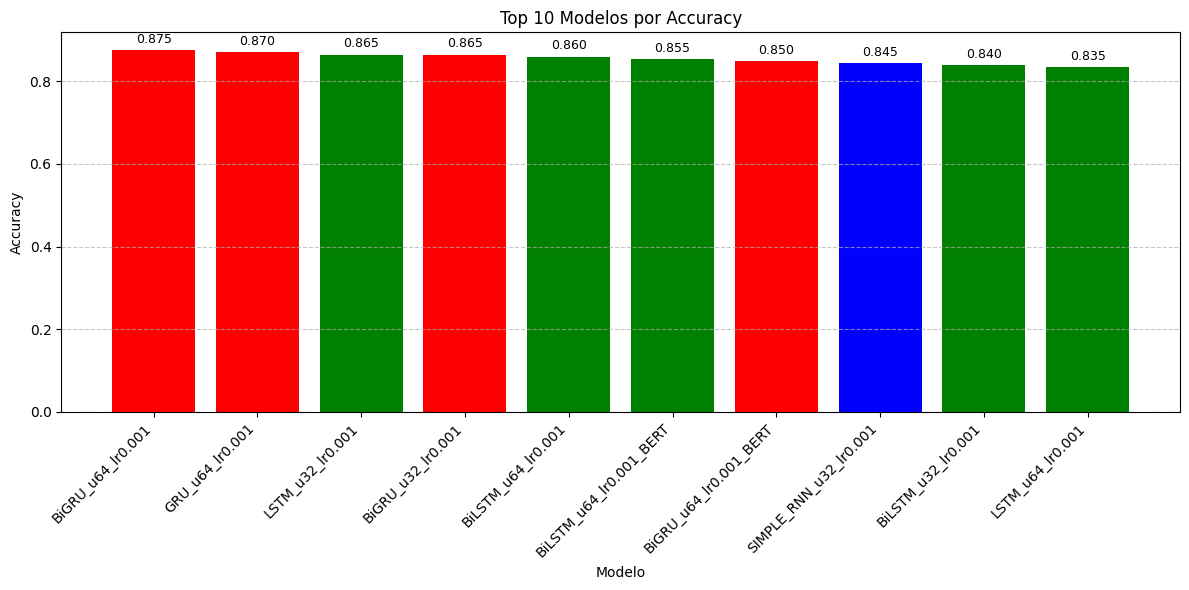

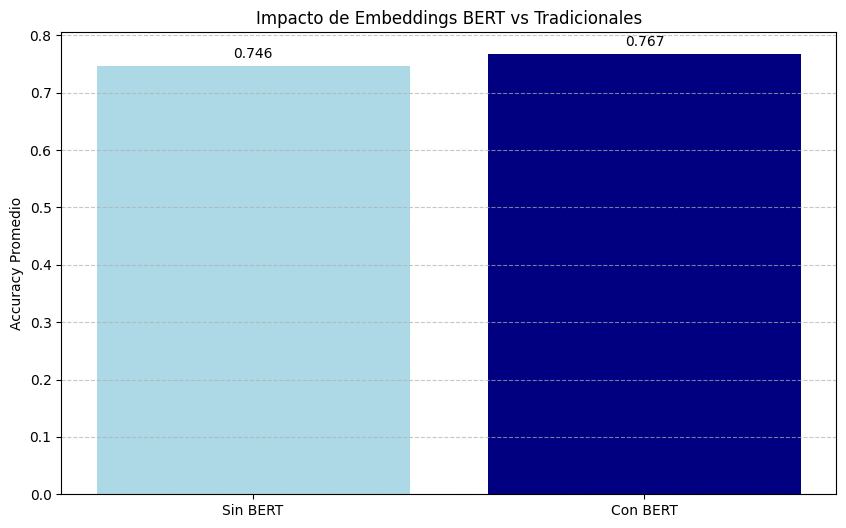

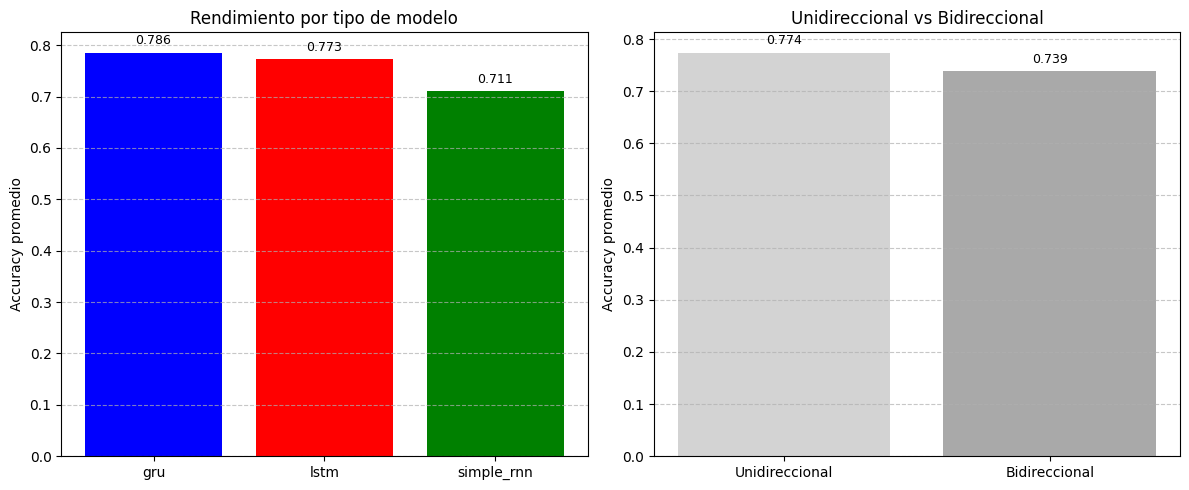


Mejor modelo: BiGRU_u64_lr0.001
Accuracy: 0.8750
F1-Score: 0.8594

Entrenando el mejor modelo con la configuración óptima...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5083 - loss: 0.9834 - val_accuracy: 0.5400 - val_loss: 0.7363
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6915 - loss: 0.6694 - val_accuracy: 0.8200 - val_loss: 0.5380
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8366 - loss: 0.4915 - val_accuracy: 0.8500 - val_loss: 0.4558
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9302 - loss: 0.2859 - val_accuracy: 0.8600 - val_loss: 0.4311
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9627 - loss: 0.1605 - val_accuracy: 0.8500 - val_loss: 0.4496
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9654 - loss: 0.0994 - val_accuracy: 0.8450 - val_loss: 0.4749
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9683 - loss: 0.0861 - val_accuracy: 0.8650 - val_loss: 0.4233
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9838 - loss: 0.0593 - val_accuracy: 0.8600 - val_loss: 0.

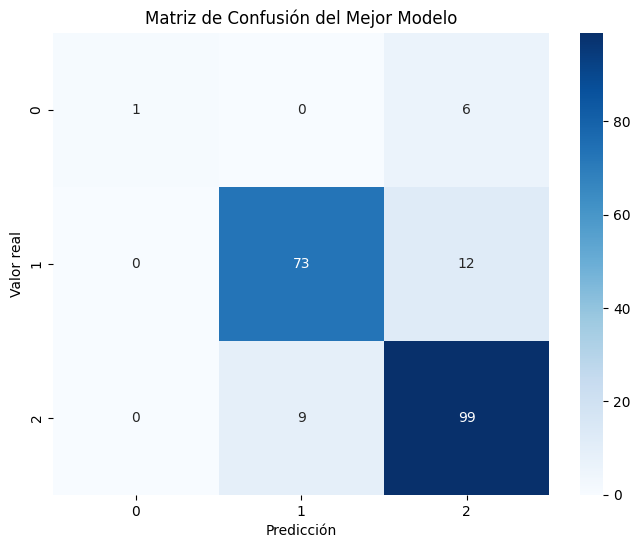


Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.89      0.86      0.87        85
           2       0.85      0.92      0.88       108

    accuracy                           0.86       200
   macro avg       0.91      0.64      0.67       200
weighted avg       0.87      0.86      0.86       200


Mejor modelo guardado como 'best_financial_sentiment_model_gru.keras'


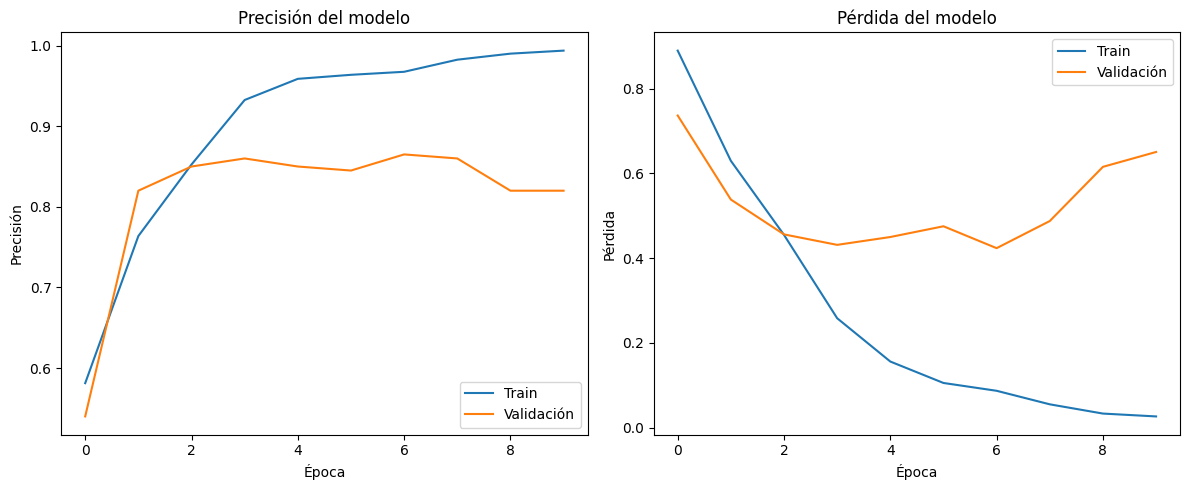


Proceso de grid search y entrenamiento completo.


In [4]:
# VISUALIZACIONES: Comparar rendimiento entre diferentes modelos


# 1. Gráfico de barras para los mejores modelos
plt.figure(figsize=(12, 6))
top_n = min(10, len(all_results_sorted))
top_models = results_df.head(top_n)['model_name'].tolist()
top_accs = results_df.head(top_n)['accuracy'].tolist()

# Colores basados en tipo de modelo
colors = []
for model_type in results_df.head(top_n)['model_type']:
    if model_type == 'simple_rnn':
        colors.append('blue')
    elif model_type == 'lstm':
        colors.append('green')
    else:  # gru
        colors.append('red')

# Gráfico
bars = plt.bar(top_models, top_accs, color=colors)
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.title('Top 10 Modelos por Accuracy')
plt.xticks(rotation=45, ha='right')

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Comparar modelos con y sin BERT
plt.figure(figsize=(10, 6))
bert_avg = results_df[results_df['use_bert']]['accuracy'].mean()
no_bert_avg = results_df[~results_df['use_bert']]['accuracy'].mean()

bars = plt.bar(['Sin BERT', 'Con BERT'], [no_bert_avg, bert_avg], color=['lightblue', 'navy'])
plt.ylabel('Accuracy Promedio')
plt.title('Impacto de Embeddings BERT vs Tradicionales')

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Comparación por tipo de modelo y bidireccionalidad
plt.figure(figsize=(12, 5))

# Subgráfico 1: Comparación por tipo de modelo
plt.subplot(1, 2, 1)
model_type_perf = results_df.groupby('model_type')['accuracy'].mean()
bars1 = plt.bar(model_type_perf.index, model_type_perf.values, color=['blue', 'red', 'green'])
plt.title('Rendimiento por tipo de modelo')
plt.ylabel('Accuracy promedio')

# Añadir valores sobre las barras
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subgráfico 2: Comparación bidireccional vs unidireccional
plt.subplot(1, 2, 2)
bidir_perf = results_df.groupby('bidirectional')['accuracy'].mean()
bars2 = plt.bar(['Unidireccional', 'Bidireccional'], bidir_perf.values, color=['lightgray', 'darkgray'])
plt.title('Unidireccional vs Bidireccional')
plt.ylabel('Accuracy promedio')

# Añadir valores sobre las barras
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Entrenar el mejor modelo con configuración óptima
best_result = all_results_sorted[0]
print(f"\nMejor modelo: {best_result['model_name']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"F1-Score: {best_result['f1_score']:.4f}")

# Crear y entrenar el mejor modelo
print("\nEntrenando el mejor modelo con la configuración óptima...")
best_model = create_rnn_model(
    model_type=best_result['model_type'],
    bidirectional=best_result['bidirectional'],
    units=best_result['units'],
    learning_rate=best_result['learning_rate'],
    dropout_rate=0.3,
    use_bert=best_result['use_bert']
)

# Early stopping con un poco más de paciencia para el modelo final
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Entrenar modelo final
history = best_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,  # Más épocas para el modelo final
    batch_size=best_result['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar modelo final
y_pred_probs = best_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df['label'].unique()),
            yticklabels=sorted(df['label'].unique()))
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión del Mejor Modelo')
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_pred))

# Guardar el mejor modelo
model_filename = f'best_financial_sentiment_model_{best_result["model_type"]}.keras'
best_model.save(model_filename)
print(f"\nMejor modelo guardado como '{model_filename}'")

# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Train', 'Validación'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Train', 'Validación'], loc='upper right')

plt.tight_layout()
plt.show()

print("\nProceso de grid search y entrenamiento completo.")